## Analysis of Yelp Business Intelligence Data
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-yelpdataset/yelp-light/*business.json

## Installation and Initial Setup
Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib

In [1]:
%%info

In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588518311504_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…




Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.4.1
seaborn                    0.10.1
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

## Importing
Now, import the installed packages from the previous block below.

In [26]:
from pyspark.sql.functions import explode

from pyspark.sql.functions import col, split, desc, ltrim, avg, year, when, array_contains, expr,size, array_except, lit, udf
from pyspark.sql.types import StringType
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data
We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [4]:
df = spark.read.json('s3://9760yelpdata/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data
Display the number of rows and columns in our dataset.

In [5]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393

Display the DataFrame schema below.

In [6]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str


Display the first 5 rows with the following columns:

*business_id

*name

*city

*state

*categories

In [7]:
cols = ("business_id","name","city","state","categories")
df.select(*cols).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

## Analyzing Categories
Let's now answer this question: how many unique categories are represented in this dataset?

### Calculating the association table:

In [29]:
#df1 = df.select(col("business_id"), explode( split(ltrim(col("categories")), ",") ).alias("categories"))
df1 = df.select(col("business_id"), explode( split(col("categories"), ",") ).alias("categories"))
df1 = df1.withColumn('categories', ltrim(df1.categories))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
## Display the first 5 rows of your association table below.
df1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows


## Total Unique Categories
Finally, we are ready to answer the question: what is the total number of unique categories available?

Below, implement the code necessary to calculate this figure.

In [39]:
print(f'Unique categories:{df1.select("categories").distinct().count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Unique categories:1336

## Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.

(i've sorted the output by count for easier reading, and later - plotting)

In [40]:
result_df = df1.select('categories').groupby(df1.categories).count().sort(desc("count"))
result_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

## Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories.

In [41]:
result_pdf = result_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

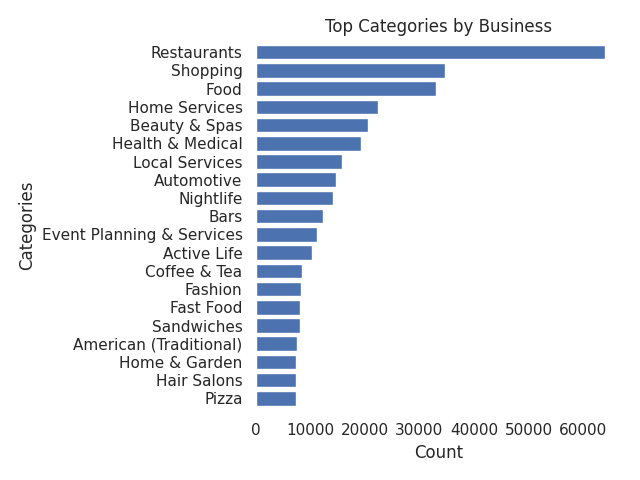

In [47]:
plt.clf()
ax = result_pdf.head(20).plot.barh(x='categories', y='count', width=.8)
plt.gca().invert_yaxis()
plt.ylabel('Categories')
plt.xlabel('Count')
plt.title('Top Categories by Business')
ax.get_legend().remove()
plt.box(False)
ax.grid(False)
plt.tight_layout()
%matplot plt

## Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

### Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are  extremely dissatisfied or extremely satisfied with the service received.
How true is this really? Let's try and answer this question.

## Loading User Data
Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [48]:
review = spark.read.json('s3://9760yelpdata/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# Total columns
print(f'Total Columns: {len(review.dtypes)}')
print(f'Total Rows: {review.count():,}')
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 9
Total Rows: 8,021,122
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the business_id and stars columns together for the user reviews data.

In [50]:
review.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who took the time to submit a written review.
the condition, in this case, is colmn 'text' is not set to Null

In [52]:
rev = review.where(col("text").isNotNull()).groupby(review.business_id).agg(avg(col("stars")))
rev.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

In [53]:
# same thing, for all reviews , not just those that have text
rev_all = review.groupby(review.business_id).agg(avg(col("stars")).alias("actual_stars"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Now the fun part - let's join our two dataframes (reviews and business data) by business_id


In [55]:
joined = df.join(rev, on=['business_id'])
joined_all = df.join(rev_all, on=['business_id'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [57]:
j = joined.select("avg(stars)","stars","name","city","state").sort("""avg(stars)""",ascending=False)
j.show(5)
j_all = joined_all.select("stars","actual_stars","name","city","state").sort("actual_stars",ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------+-----+
|avg(stars)|stars|                name|     city|state|
+----------+-----+--------------------+---------+-----+
|       5.0|  5.0|Mike's Mobile Aut...|  Gilbert|   AZ|
|       5.0|  5.0|   RateWise Mortgage|Las Vegas|   NV|
|       5.0|  5.0|Amanda B. Wedding...|Las Vegas|   NV|
|       5.0|  5.0|Schiffman Law Off...|  Phoenix|   AZ|
|       5.0|  5.0|     Chillout Lounge|Henderson|   NV|
+----------+-----+--------------------+---------+-----+
only showing top 5 rows


Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

The formula you can use is something like:

(row['avg(stars)'] - row['stars']) / row['stars']

In [58]:
new_df = j.withColumn("skew_score", ((j["""avg(stars)"""]-j_all["stars"])/j["stars"])).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

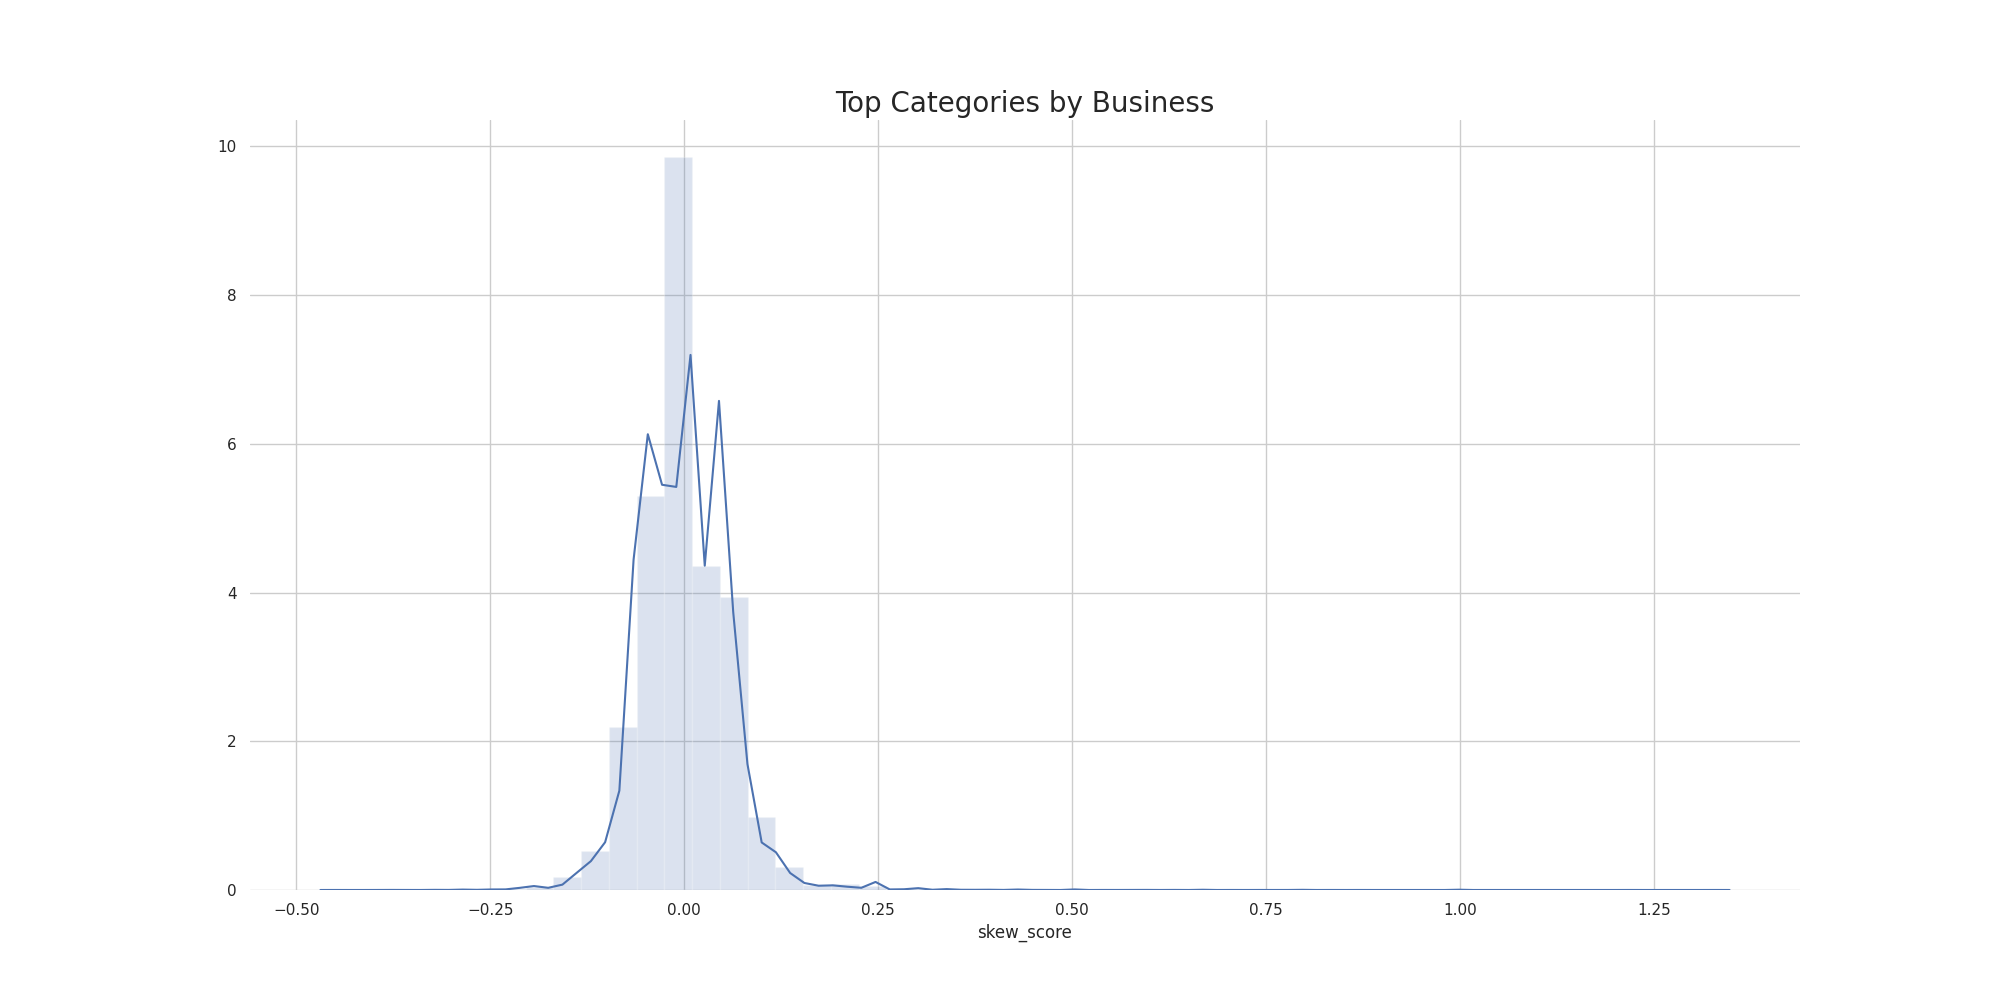

In [59]:
plt.clf()
plt.figure(figsize=(20,10))
sns.distplot(new_df["skew_score"], hist_kws=dict(alpha=0.2))
plt.title('Top Categories by Business', fontsize=20)
plt.box(False)
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

With a positive skewness score, this histogram has a longer tail to the right and so it is positively skewed, not negatively. The score is <1 , which is usually not considered a "heavy skew"

### last part! i'll try to answer the question : 
"how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating."

Load user data set, and join with review on user_id

In [61]:
user = spark.read.json('s3://9760yelpdata/yelp_academic_dataset_user.json')
user_rev = review.join(user, on='user_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Add a column where i've taken the year alone from the date of each review:

In [62]:
user_rev = user_rev.withColumn("year",year("date").cast('String'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

this UDF will check whether a var is contained within another. Using this, we can later check whether a review was given by an 'elite' user , or not. If the year the review was given at is contained within the 'elite' column, the review will be set to "elite review"

In [63]:
def contains(x,y):
  z = len(set(x) - set(y))
  if z == 0:
    return True
  else:
    return False

contains_udf = udf(contains)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
years = user_rev.select('year')
elites = user_rev.select('elite')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
user_rev = user_rev.withColumn("elite_rev", contains_udf(*years,*elites))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
user_rev = user_rev.join(rev_all.select("business_id","actual_stars"),on=['business_id'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cast to pandas dataframe in order to later plot :

In [68]:
user_rev_pd = user_rev.select('business_id','stars','actual_stars','elite_rev','year').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

i'll create a 'diff' column, to represent the difference between stars given in a review and the actual star-count of a business. Later, i will compare the average and variance of this "accuracy" between elite and non-elite reviews

In [69]:
user_rev_pd['diff'] = user_rev_pd['actual_stars']-user_rev_pd['stars']
user_rev_pd['elite_rev'] = np.where(user_rev_pd['elite_rev']=='true','Elite Review','Non-Elite Review')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# lets graph it! 
 i'll create a boxplot, with the median represented as a line in the middle of a box representing the IQR (interquartile range) - 50% of the data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

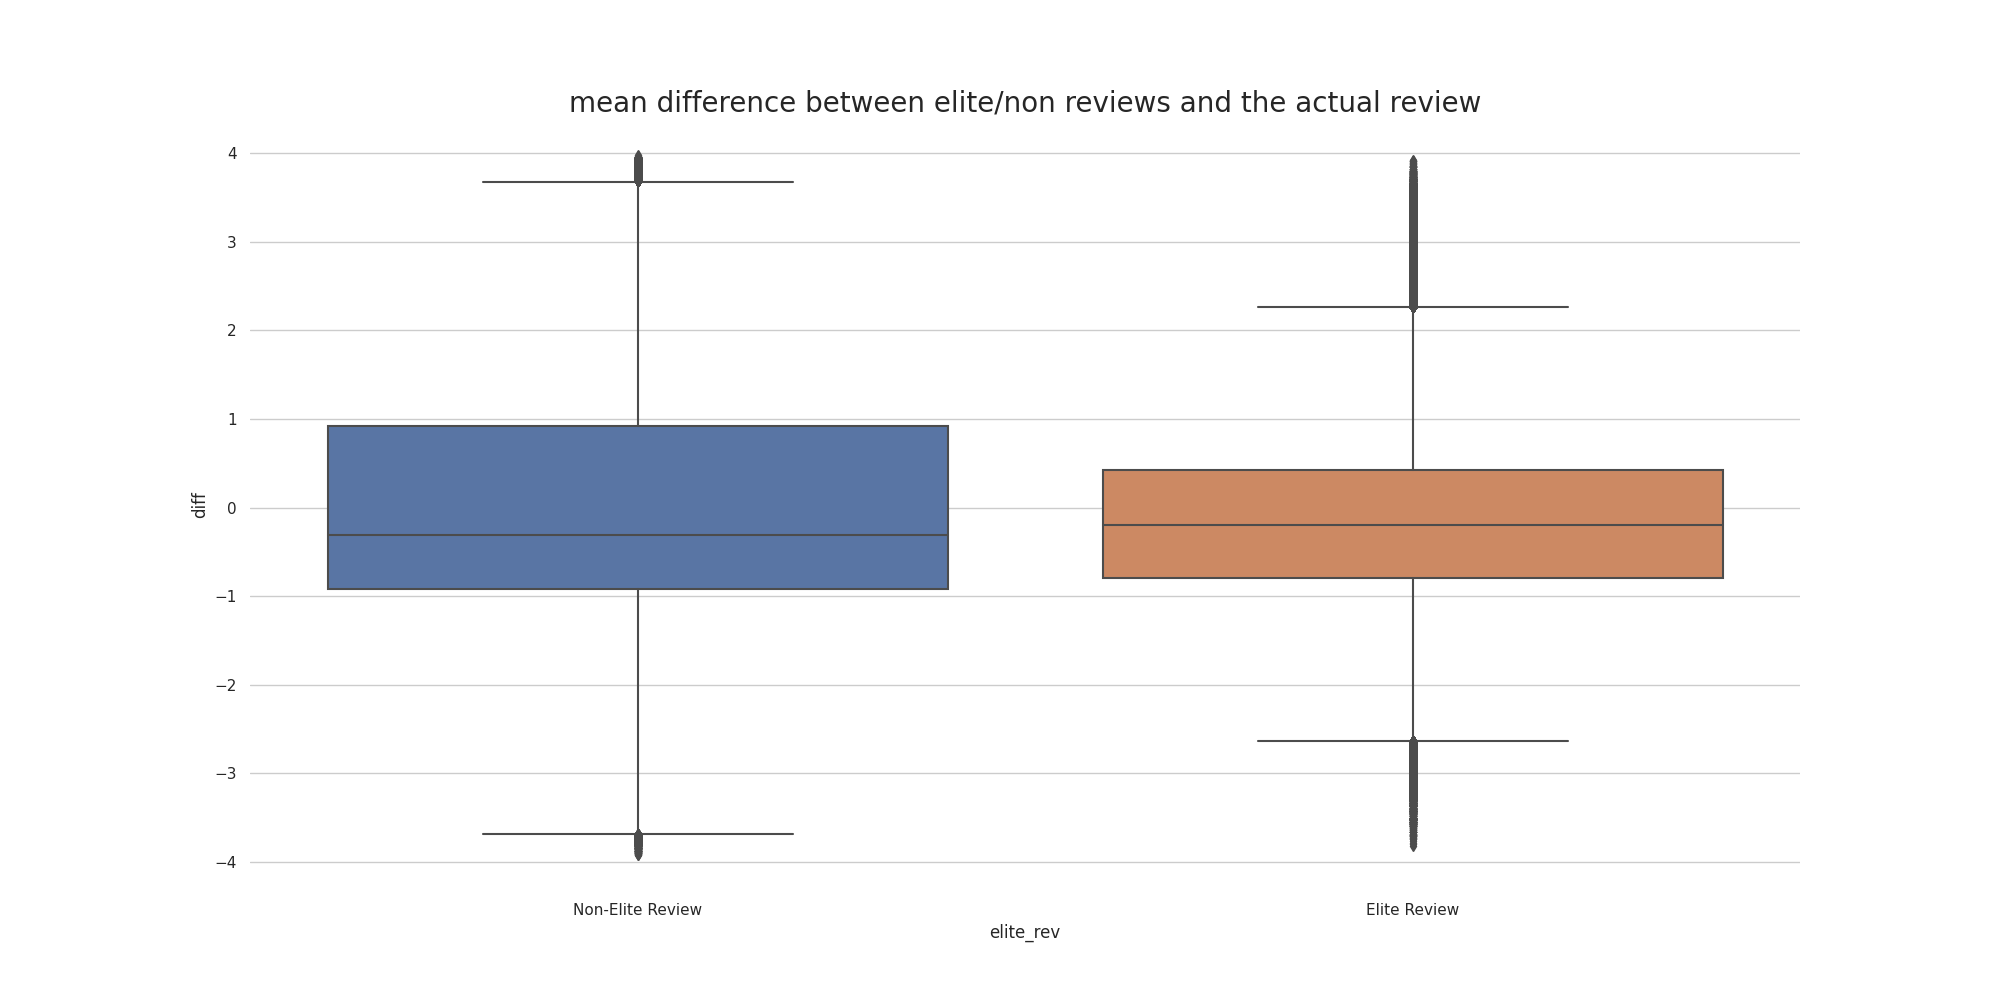

In [70]:
plt.clf()
ax = sns.boxplot(x='elite_rev', y="diff", data=user_rev_pd)
plt.title('mean difference between elite/non reviews and the actual review', fontsize=20)
plt.box(False)
%matplot plt

we can see that Elite reviews are not only closer to the actualy score, but have a lower variance too, as in ~50% of scores are closer to eachother and to the actual average than non-elite reviews. 
After doing this analysis, i would definately count on elite reviews more than i have so far